In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Data sets

Data collected from https://catalog.data.gov/dataset?res_format=CSV&tags=weather and https://www.bgc-jena.mpg.de/index.php/Main/HomePage

zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

df = pd.read_csv(csv_path)

In [4]:
#df = pd.read_csv(r'https://data.townofcary.org/api/v2/catalog/datasets/rdu-weather-history/exports/csv', sep=';')

In [5]:
df = pd.read_csv(r'pca_weakly_2018.zip', compression='zip')
df = df.set_index('Datetime')

In [6]:
df.shape

(525600, 4)

In [7]:
df.head()

,gic,principal component 1,principal component 2,principal component 3
Datetime,,,,
2018-01-01 00:00:00,0.17,2522.722352,4980.099206,40.021187
2018-01-01 00:01:00,0.17,6791.115197,-1006.520481,-115.982313
2018-01-01 00:02:00,0.22,6506.883006,-1160.397033,-101.734742
2018-01-01 00:03:00,0.13,6644.695906,-1427.581950,-119.780090
2018-01-01 00:04:00,0.09,6574.535937,-1321.890212,-131.641522


In [8]:
df.isnull().sum()

gic                      0
principal component 1    0
principal component 2    0
principal component 3    0
dtype: int64

In [9]:
df.fillna(method='ffill', inplace=True)

In [10]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [11]:
TRAIN_SPLIT = 3000

In [12]:
tf.random.set_seed(13) #in order to reproduce

In [13]:
uni_data = df['gic']
uni_data.index = df.index
uni_data.head()

Datetime
2018-01-01 00:00:00    0.17
2018-01-01 00:01:00    0.17
2018-01-01 00:02:00    0.22
2018-01-01 00:03:00    0.13
2018-01-01 00:04:00    0.09
Name: gic, dtype: float64

In [14]:
# uni_data = df['T (degC)']
# uni_data.index = df['Date Time']
# uni_data.head()

F:\Astra\conda2\envs\Austin\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


array([<AxesSubplot:xlabel='Datetime'>], dtype=object)

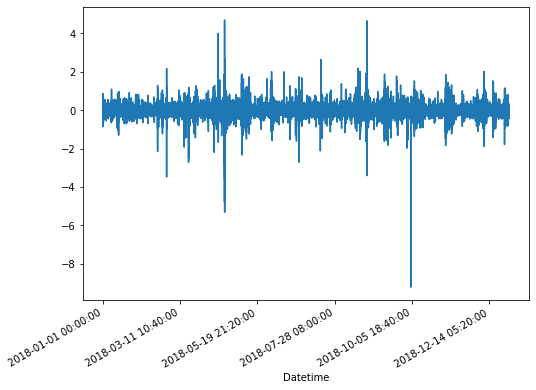

In [15]:
uni_data.plot(subplots=True)

In [16]:
uni_data = uni_data.values

scale features 

In [17]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_train_std

0.1518546453758403

standardize the data

In [18]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [19]:
uni_data.shape

(525600,)

In [20]:
univariate_past_history = 20 #look into the past how far
univariate_future_target = 0 #what day to predict next day zero

In [21]:
#split data
x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [22]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[ 1.16885899]
 [ 1.16885899]
 [ 1.49812122]
 [ 0.9054492 ]
 [ 0.64203941]
 [ 0.7737443 ]
 [ 0.44448207]
 [ 1.10300654]
 [ 1.03715409]
 [ 1.03715409]
 [ 0.7737443 ]
 [ 1.03715409]
 [ 0.37862962]
 [-0.3457473 ]
 [ 0.31277717]
 [ 1.10300654]
 [ 1.36641633]
 [ 1.16885899]
 [-0.01648506]
 [-0.01648506]]

 Target temperature to predict
-0.14818995676844507


In [23]:
def create_time_steps(length):
  return list(range(-length, 0))

In [24]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

Example of what we are attemping to predict vs acutall

<module 'matplotlib.pyplot' from 'F:\\Astra\\conda2\\envs\\Austin\\lib\\site-packages\\matplotlib\\pyplot.py'>

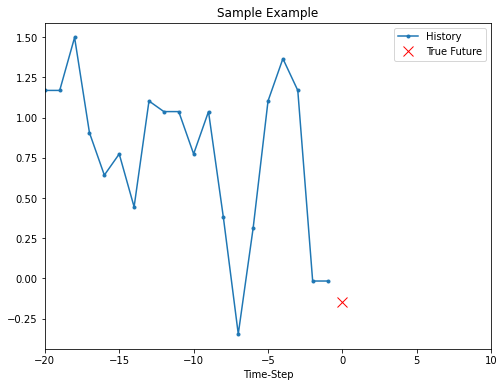

In [25]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

let's first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 20 observations.

Benchmark

In [26]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from 'F:\\Astra\\conda2\\envs\\Austin\\lib\\site-packages\\matplotlib\\pyplot.py'>

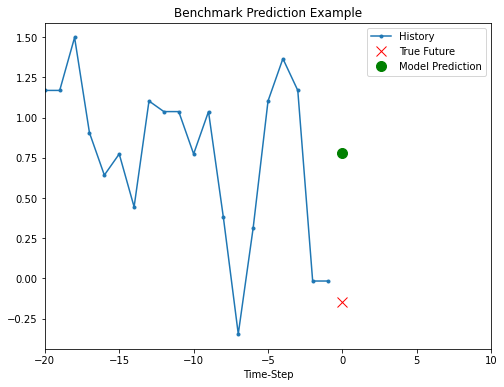

In [27]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Benchmark Prediction Example')

Let's see if you can beat this baseline using a recurrent neural network.

In [28]:
BATCH_SIZE = 50
BUFFER_SIZE = 100

In [29]:
#shuffle data --- every day im suffling
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

#### Model
LSTM requires the input shape of the data it is being given.

In [30]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [31]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(50, 1)


In [195]:
EVALUATION_INTERVAL = 255 #epoch will only run for 30 steps - set back to one
EPOCHS = 40

In [111]:


simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/40
5/5 [==============================] - 0s 20ms/step - loss: 0.4656 - val_loss: 0.2753
Epoch 2/40
5/5 [==============================] - 0s 20ms/step - loss: 0.4005 - val_loss: 0.2746
Epoch 3/40
5/5 [==============================] - 0s 19ms/step - loss: 0.4327 - val_loss: 0.2738
Epoch 4/40
5/5 [==============================] - ETA: 0s - loss: 0.492 - 0s 20ms/step - loss: 0.5332 - val_loss: 0.2731
Epoch 5/40
5/5 [==============================] - 0s 24ms/step - loss: 0.4682 - val_loss: 0.2731
Epoch 6/40
5/5 [==============================] - 0s 19ms/step - loss: 0.2992 - val_loss: 0.2736
Epoch 7/40
5/5 [==============================] - 0s 19ms/step - loss: 0.2531 - val_loss: 0.2739
Epoch 8/40
5/5 [==============================] - 0s 19ms/step - loss: 0.2400 - val_loss: 0.2755
Epoch 9/40
5/5 [==============================] - 0s 19ms/step - loss: 0.4365 - val_loss: 0.2775
Epoch 10/40
5/5 [==============================] - 0s 19ms/step - loss: 0.4032 - val_loss: 0.2783
Epoch

Predicted : [0.5215425]
Actual : 0.905449196673321


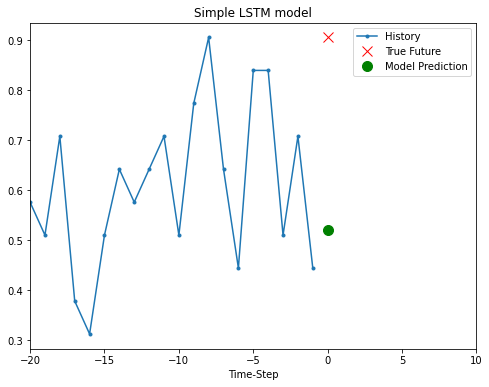

Predicted : [0.5832764]
Actual : 0.8395967495832106


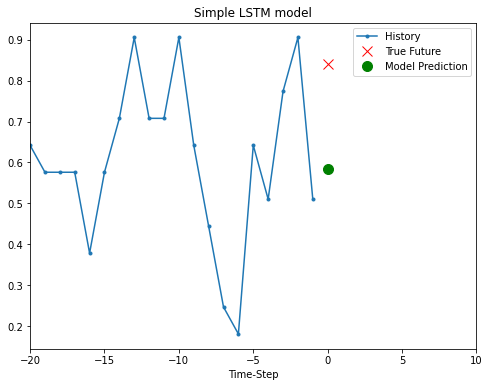

Predicted : [0.6515496]
Actual : 0.905449196673321


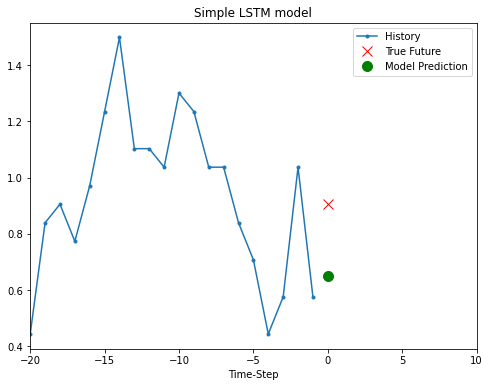

In [34]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  print('Predicted : {}'.format(simple_lstm_model.predict(x)[0]))
  print('Actual : {}'.format(y[0]))
  plot.show()

looks better than the baseline. Now that you have seen the basics, let's move on to part two, where you will work with a multivariate time series.

### multivariate time series

In [35]:
df.columns

Index(['gic', 'principal component 1', 'principal component 2',
       'principal component 3'],
      dtype='object')

In [36]:
features_considered=[ 'principal component 1','gic', 'principal component 3']

In [37]:
features = df[features_considered]
features.index = df.index
features.head()

,principal component 1,gic,principal component 3
Datetime,,,
2018-01-01 00:00:00,2522.722352,0.17,40.021187
2018-01-01 00:01:00,6791.115197,0.17,-115.982313
2018-01-01 00:02:00,6506.883006,0.22,-101.734742
2018-01-01 00:03:00,6644.695906,0.13,-119.780090
2018-01-01 00:04:00,6574.535937,0.09,-131.641522


F:\Astra\conda2\envs\Austin\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
F:\Astra\conda2\envs\Austin\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
F:\Astra\conda2\envs\Austin\lib\site-packages\pandas\plotting\_matplotlib\tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
F:\Astra\conda2\envs\Austin\lib\site-packages\pandas\plo

array([<AxesSubplot:xlabel='Datetime'>, <AxesSubplot:xlabel='Datetime'>,
       <AxesSubplot:xlabel='Datetime'>], dtype=object)

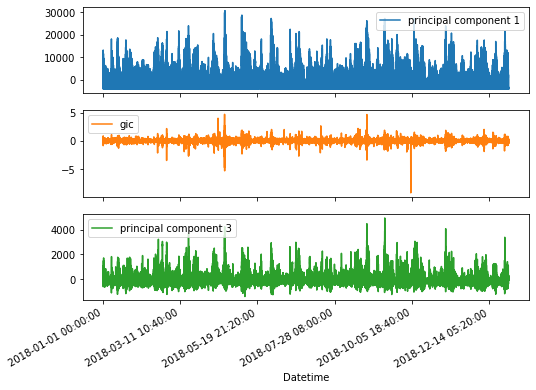

In [38]:
features.plot(subplots=True)

scaling/standardize

In [196]:
features.values

array([[ 2.52272235e+03,  1.70000000e-01,  4.00211867e+01],
       [ 6.79111520e+03,  1.70000000e-01, -1.15982313e+02],
       [ 6.50688301e+03,  2.20000000e-01, -1.01734742e+02],
       ...,
       [-3.86461945e+03,  9.00000000e-02,  1.29874691e+01],
       [-3.81937399e+03,  1.10000000e-01,  9.95334138e+01],
       [-3.77414593e+03,  1.20000000e-01,  1.03482732e+02]])

In [197]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
data_std

array([3.70970815e+03, 1.51854645e-01, 3.42420581e+02])

In [198]:
dataset = (dataset-data_mean)/data_std

In [199]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

the model will be given the last 20 recorded temperature observations, and needs to learn` to predict the temperature at the next time step.

In [200]:
past_history = 30 #past 30 days
future_target = 2 #what day to predict
STEP = 3 #adjustment for iterations/steps similar to epocks

In [201]:

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [202]:
y_train_single

array([1.23471143, 1.23471143, 0.70789186, ..., 0.64203941, 0.57618696,
       0.51033451])

In [203]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (10, 3)


In [204]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [205]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [206]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(50, 1)


Train model

In [207]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/40
255/255 [==============================] - 1s 4ms/step - loss: 0.6009 - val_loss: 0.3913
Epoch 2/40
255/255 [==============================] - 1s 3ms/step - loss: 0.5498 - val_loss: 0.4000
Epoch 3/40
255/255 [==============================] - 1s 3ms/step - loss: 0.5304 - val_loss: 0.4188
Epoch 4/40
255/255 [==============================] - 1s 3ms/step - loss: 0.5225 - val_loss: 0.3897
Epoch 5/40
255/255 [==============================] - 1s 3ms/step - loss: 0.5359 - val_loss: 0.4016
Epoch 6/40
255/255 [==============================] - 1s 3ms/step - loss: 0.5141 - val_loss: 0.4110
Epoch 7/40
255/255 [==============================] - 1s 3ms/step - loss: 0.5005 - val_loss: 0.4213
Epoch 8/40
255/255 [==============================] - 1s 3ms/step - loss: 0.4912 - val_loss: 0.3976
Epoch 9/40
255/255 [==============================] - 1s 4ms/step - loss: 0.4996 - val_loss: 0.4049
Epoch 10/40
255/255 [==============================] - 1s 3ms/step - loss: 0.4779 - val_loss: 0.4198

In [208]:
'''Plot the train/validation loss against on another'''
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

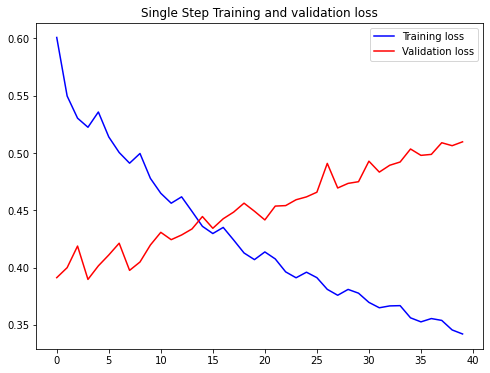

In [209]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

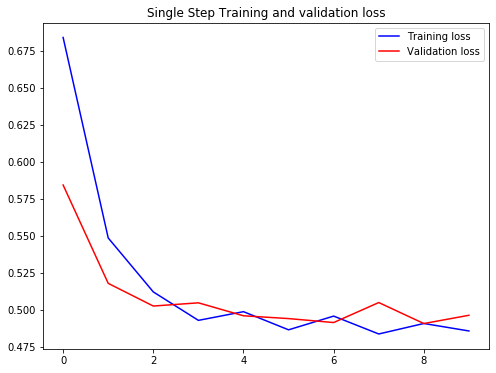

In [201]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

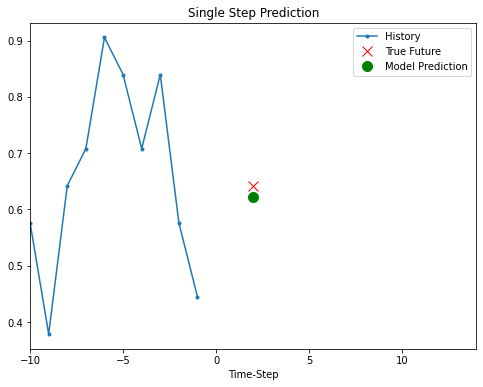

Predicted : [0.6213174]
Actual : 0.6420394083128795


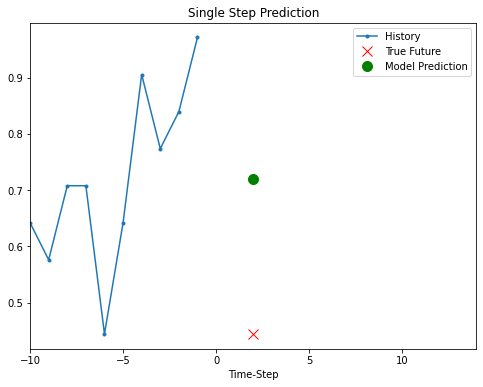

Predicted : [0.720348]
Actual : 0.4444820670425484


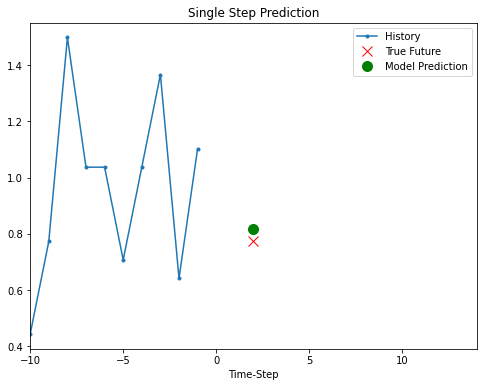

Predicted : [0.81773984]
Actual : 0.7737443024931003


In [54]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], (2),
                   'Single Step Prediction')
  plot.show()
  print('Predicted : {}'.format(single_step_model.predict(x)[0]))
  print('Actual : {}'.format(y[0]))

### Predict a range of future values

In [210]:
future_target = 5 #samples from the last 5 days

In [211]:
#split data 
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [212]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (10, 3)

 Target temperature to predict : (5,)


In [213]:
#tf.data to shuffle, batch, and cache the dataset.
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [214]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

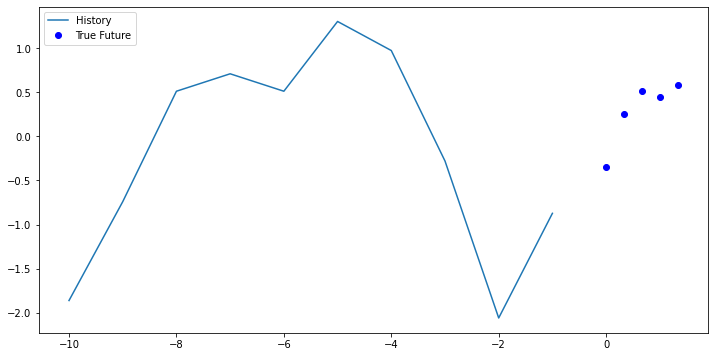

In [215]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

Model

In [216]:
import datetime

In [217]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(5))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae',metrics=['accuracy'])

log_dir = r"C:\Users\cgree\Documents\logs\fit" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [218]:
for x, y in val_data_multi.take(1):
  print(multi_step_model.predict(x).shape)
  print(y.shape)

(50, 5)
(50, 5)


In [ ]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50,
                                          callbacks=[tensorboard_callback])

Epoch 1/40
255/255 [==============================] - 2s 7ms/step - loss: 0.6797 - accuracy: 0.2168 - val_loss: 0.4548 - val_accuracy: 0.2108
Epoch 2/40
255/255 [==============================] - 1s 5ms/step - loss: 0.5809 - accuracy: 0.2051 - val_loss: 0.4578 - val_accuracy: 0.2004
Epoch 3/40
255/255 [==============================] - 1s 5ms/step - loss: 0.5373 - accuracy: 0.2105 - val_loss: 0.4449 - val_accuracy: 0.2232
Epoch 4/40
255/255 [==============================] - 1s 5ms/step - loss: 0.5159 - accuracy: 0.2192 - val_loss: 0.3858 - val_accuracy: 0.2192
Epoch 5/40
255/255 [==============================] - 1s 5ms/step - loss: 0.5241 - accuracy: 0.2218 - val_loss: 0.4083 - val_accuracy: 0.2068
Epoch 6/40
255/255 [==============================] - 1s 5ms/step - loss: 0.5046 - accuracy: 0.2129 - val_loss: 0.4313 - val_accuracy: 0.2032
Epoch 7/40
255/255 [==============================] - 1s 5ms/step - loss: 0.4927 - accuracy: 0.2189 - val_loss: 0.4617 - val_accuracy: 0.1960
Epoch 

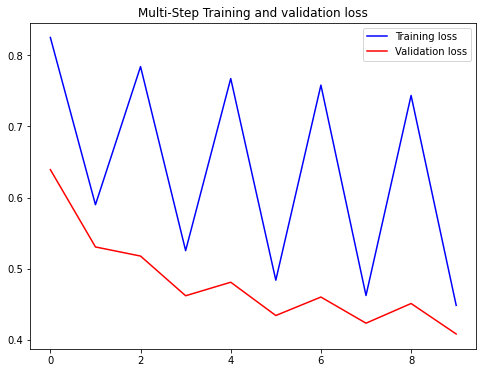

In [65]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

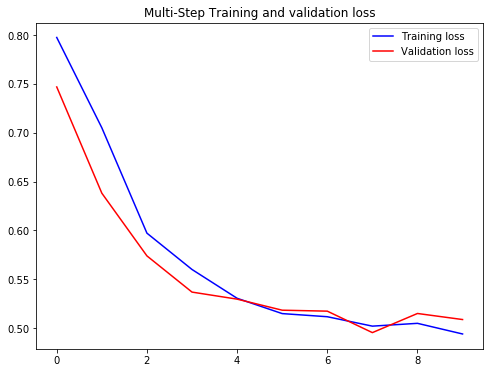

In [213]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

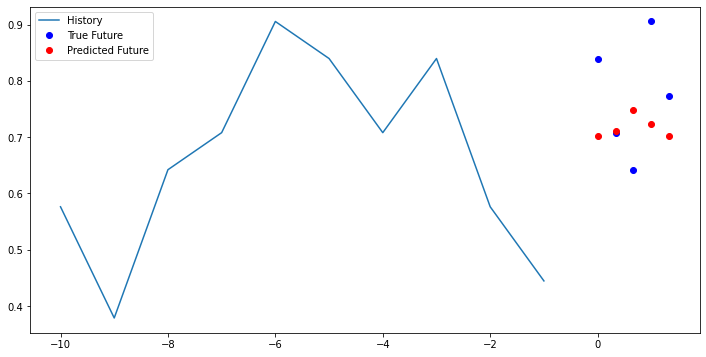

Predicted : [0.70157635 0.7107     0.7487028  0.72296965 0.7010676 ]
Actual : [0.83959675 0.70789186 0.64203941 0.9054492  0.7737443 ]
Difference : [-0.1380204   0.00280812  0.10666342 -0.18247955 -0.07267668]


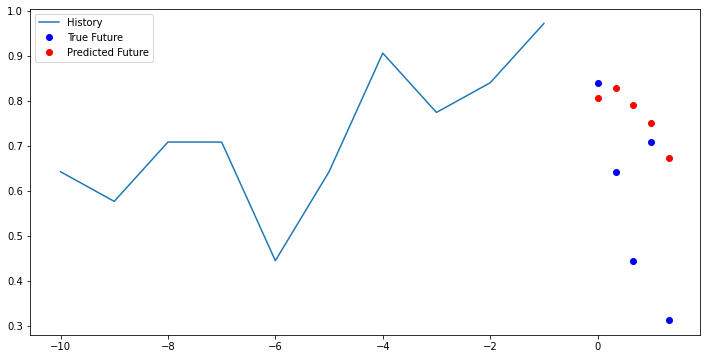

Predicted : [0.8059557  0.82829666 0.7913071  0.75068116 0.6725373 ]
Actual : [0.83959675 0.64203941 0.44448207 0.70789186 0.31277717]
Difference : [-0.03364104  0.18625725  0.34682502  0.04278931  0.35976015]


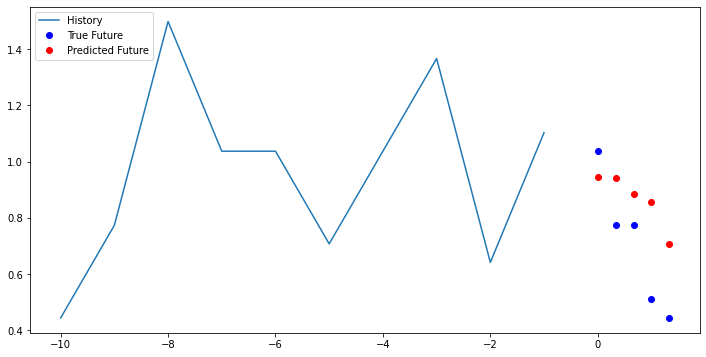

Predicted : [0.9444121  0.9408372  0.8860038  0.85551655 0.7083272 ]
Actual : [1.03715409 0.7737443  0.7737443  0.51033451 0.44448207]
Difference : [-0.09274198  0.1670929   0.11225949  0.34518204  0.26384511]


In [66]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])
  print('Predicted : {}'.format(multi_step_model.predict(x)[0]))
  print('Actual : {}'.format(y[0]))
  print('Difference : {}'.format(multi_step_model.predict(x)[0]-(y[0])))

In [95]:
def R_squared(y, y_pred):
    
  residual = tf.reduce_sum(tf.square(tf.subtract(y,y_pred)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  r2 = tf.subtract(1.0, tf.div(residual, total))
  return r2